# Network Inference
This code will take data from Kaggle's connectomics dataset (https://www.kaggle.com/c/connectomics) and attempt to infer undirected neuronal connectivity from simulated calcium imaging traces. The basic plan is to use Granger causality, F tests, and the Benjamini-Hochberg procedure to identify connections between neurons.

## Look at the Data

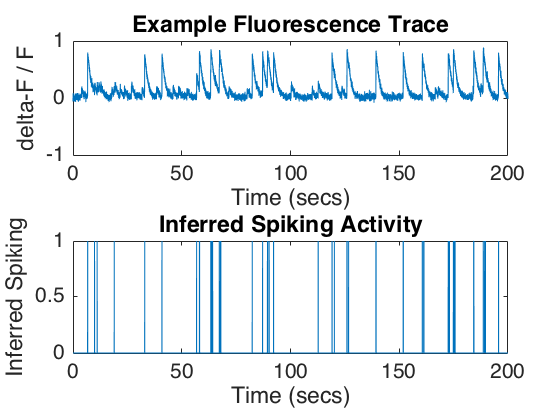

In [2]:
% load in reduced size data, along with inferred spike train from L0 algorithm
load Small_Fluo_normal-1.mat
[timeBins,numNeurons] = size(F);
Fs = 50;time = linspace(0,timeBins/Fs,timeBins);
figure;subplot(2,1,1);
plot(time,F(:,1));title('Example Fluorescence Trace');
xlabel('Time (secs)');ylabel('delta-F / F');
subplot(2,1,2);
plot(time,est_spike);title('Inferred Spiking Activity');
xlabel('Time (secs)');ylabel('Inferred Spiking');

The simulated fluorescence traces look very clean (better than real data) and the L0 algorithm seems to do quite well in inferring spike times. I'm having some trouble getting the L0 algorithm to work without overfitting, however, so here I've arbitrarily chosen the sparsity constraint, lambda. In addition, the version of the algorithm that I created is quite slow, so I was unable to infer spiking activity for all of the neurons. Sean Jewell (first author of L0 algorithm paper) recently added a faster version to Github, but it's in R and I haven't downloaded it yet (it exploits a new log-linear time algorithm for changepoint detection described here: https://arxiv.org/abs/1703.03352 ... this algorithm is supposed to be 2 orders of magnitude faster than the previous one, which would make it as fast or faster than the OASIS algorithms).

In what follows, I use the raw fluorescence traces for all inference procedures and assume the data are normally distributed. Ideally, though, the inference procedures would be performed after inferring spike times, assuming a binomial distribution, Poisson, negative binomial, etc. Deconvolution has the effect of denoising the fluorescence trace and removing the deterministic calcium decay. I'm not positive about his, but I suspect the deterministic calcium decay will lead to two issues in inferring network connectivity: 1) it may give rise to arbitrary correlations between neurons that are not connected; and 2) you will be "overly confident" in your network because two neurons that spike together will have correlated activity for many consecutive time bins, the temporal extent of the calcium decay. If the inference were done with the same number of time bins but the deconvolved spiking activity, the same two neurons would only be correlated for one or two bins at a time.

## Pairwise Granger Causality

If a given neuron's fluorescence trace is defined as F$_{i}$  (i-th neuron), the history of the fluorescence trace is $H_{i}$, the total number of neurons is N, and the total number of time bins is T, then Granger causality amounts to model comparison between:

1: F$_{i}$ = $\beta$$_{0}$ + H$_{i}$$\beta$$_{1}$ + F$_{!i}$$\beta$$_{2}$ + $\epsilon$
  
2: F$_{i}$ = $\beta$$_{0}$ + H$_{i}$$\beta$$_{1}$ + F$_{!i,!j}$$\beta$$_{2}$ + $\epsilon$

If F is a T-by-1 vector, then H$_{i}$ is a T-by-h matrix representing the history of the process up to, but not including, the current time bin. The notation F$_{!i}$ means the fluorescence activity of all neurons except the i-th  neuron.  $\beta$$_{1}$ is then an h-by-1 vector of parameters and $\beta$$_{2}$ is an (N-1)-by-1 vector of parameters for model 1 and an (N-2)-by-1 vector for model 2. Model 1 describes the stochastic process for the i-th neuron as a function of a constant baseline, its own history up to lag h, and the current activity of all other neurons. Model 2 excludes neuron j from model 1 and, therefore, models 1 and 2 are nested. 

Assuming the errors are independent and identically, normally distributed, then an F test can be used for model comparison. The F test compares the sum of squared residuals of model 1 versus those of model 2, while accounting for the fact that model 2 has one fewer parameter. In essence, we're asking the question: Is my model for neuron i significantly better if I include neuron j? The full model, model 1, has 1+h+(N-1) parameters, which in our case will be 1010 parameters. I run an F test for every possible pairwise connection (except a neuron with itself), in each direction, for a total of 1000 neurons * 1000 neurons - 1000 neurons = 9.99e5 tests. This yields a non-symmetric matrix of F test p-values, with zeroes on the diagonal. This is a multiple comparison problem, which I address with the Benjamini-Hochberg procedure, described below. 

## Test Granger Causality for One Pair of Neurons

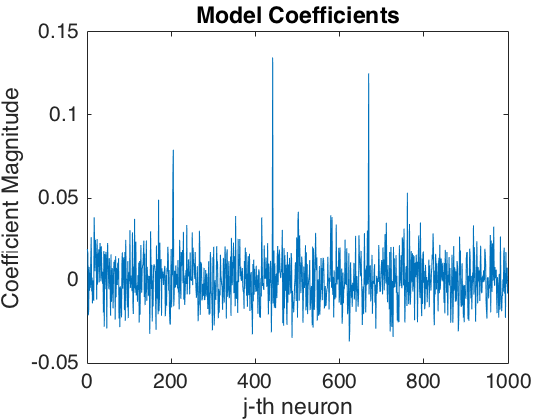

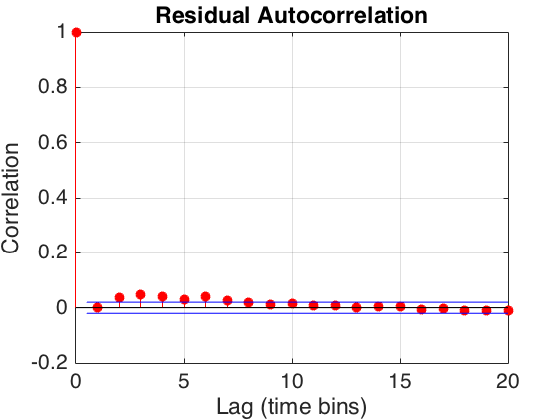

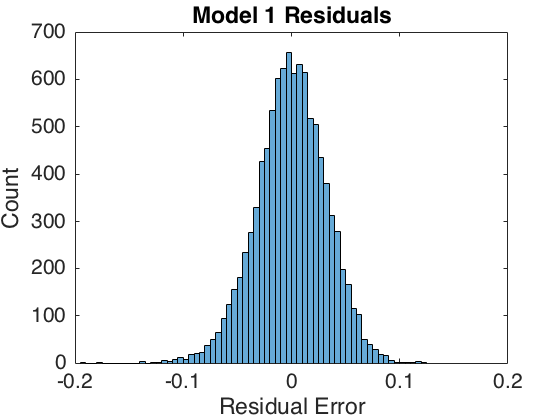

Run-time for one pairwise comparison: 2.61 seconds
Coefficient for Neuron 2: 0.02
F test p-value: 0.03


In [5]:
load Small_Fluo_normal-1.mat
[timeBins,numNeurons] = size(F);
h = 20;neuron1 = 1;neuron2 = 57;
Y = F(h+1:end,neuron1);
H = zeros(length(Y),h);

for ii=1:h
    H(:,ii) = F(h+1-ii:end-ii,neuron1);
end

% fit model 1 (the full model)
inds = find((1:numNeurons)~=neuron1);
Design = [ones(length(Y),1),H,F(h+1:end,inds)];
tic;
b1 = Design\Y;runtime = toc;
residuals = Design*b1-Y;
fullDev = sum((residuals).^2);

% fit model 2 (the restricted model, by excluding neuron 2)
inds = find((1:numNeurons)~=neuron1 & (1:numNeurons)~=neuron2);
Design = [ones(length(Y),1),H,F(h+1:end,inds)];
b = Design\Y;
residuals2 = Design*b-Y;
restrictDev = sum((residuals2).^2);

fullParams = 1+h+numNeurons-1;
Fstat = (restrictDev-fullDev)/(fullDev/(timeBins-fullParams-1));
pVal = fcdf(Fstat,1,timeBins-fullParams,'upper');

fprintf('Run-time for one pairwise comparison: %3.2f seconds\n',runtime);
fprintf('Coefficient for Neuron 2: %3.2f\n',b1(1+h+neuron2));
fprintf('F test p-value: %3.2f\n',pVal);

figure;
histogram(residuals);title('Model 1 Residuals');
xlabel('Residual Error');ylabel('Count');

figure;
autocorr(residuals,20);
title('Residual Autocorrelation');
xlabel('Lag (time bins)');ylabel('Correlation');

figure;
plot(b1(1+h+1:end));title('Model Coefficients');
xlabel('j-th neuron');ylabel('Coefficient Magnitude');

Here, we see that the p-value for this connection (from neuron 57 to neuron 1) is low, but it would probably not be identified as a true connection (depending, of course, on the type of multiple comparisons correction used). When we look at the true network for this dataset (normal-1), we see that there is no connection between these neurons. In addition, the two large peaks in this plot correspond to neurons with known connectivity to neuron 1 (433,648), while the third largest peak is for a neuron (201) not connected to neuron 1. 

The residual error histogram and the residual autocorrelation suggest that this model is misspecified. The errors skew left in the histogram (a test for normality would be appropriate). The second plot also shows significant autocorrelation structure for lags beyond 0, which indicates that the errors are not independent. Poor goodness-of-fit means the F test will not work exactly as advertised. The autocorrelated residuals may be part of the reason why the p-value for the above test is as low as it is.

Despite this concern, I'll use this model, with the caveat that I know it's not ideal. Using the spike times and a Poisson distribution would probably be better.

The time needed to fit one model (2.6 seconds) indicates that this procedure is completely impractical for a large dataset. Here, I've reduced the number of time bins to 10K. If I were to run this in series for each of the 9.99e5 tests proposed above, this would require 32 days of computing time. I've therefore run this procedure on the shared computing cluster with 32 CPUs to parallelize the computation, giving an estimated run-time of 24 hours. 

Finally, these models fit the activity of neuron i as a function of all other neurons j at the same time bin (i.e. no history). For the 50 Hz sampling rate, we would ideally include two or even three time bins, which would raise the number of parameters to about 3 times the number of neurons. This would surely take even longer to compute.

## FDR Benjamini-Hochberg for Multiple Comparisons

The 1000-by-1000 matrix of F test p-values should be sufficient to determine the connectivity of the network. However, we need to threshold the p-values in some way in order to determine a connection versus a no connection. The Benjamini-Hochberg procedure is a tool for multiple comparisons that controls the "false discovery rate" or FDR or the proportion of Type 1 errors. It works by the following algorithm:

1: Choose a false discovery rate, $\alpha$ 
 
2: Set m to be the number of tests performed
  
3: Sort the p-values in ascending order and plot them with the values {1,...,m} on the x-axis
  
4: Draw a line on the same axis with slope $\frac{\alpha}{m}$ and y-intercept zero

5: Choose the p-value threshold to be the largest p-value that falls below the $\frac{\alpha}{m}$ line

6: Any p-values below threshold are declared a connection (1) and any above the threshold are declared a no connection (0)
 
In this case, I declare an undirected connection if the F test p-value for a given pair of neurons falls below the threshold for either direction. The ROC curve is obtained by adjusting the false discovery rate, $\alpha$, over a range of values.

## Code To Fit Models and Run F tests

In [ ]:
load('fluorescence_normal-4.mat');

% use a much smaller subset of the data
reduceData = data(5001:15000,:);
[N,numNeurons] = size(reduceData);

% declare matrices to hold the model sum of squared residuals (deviances)
connectivityMatrix1 = zeros(numNeurons,numNeurons);
connectivityMatrix2 = zeros(numNeurons,numNeurons);
histParams = 10;
allInds = 1:numNeurons;
for ii=1:numNeurons
    % get data for neuron ii
    Y = reduceData(histParams+1:end,ii);
    
    % get history dependence for neuron ii
    H = zeros(length(Y),histParams);
    for jj=1:histParams
       H(:,jj) = reduceData(histParams+1-jj:end-jj,ii); 
    end
    inds = find(allInds~=ii);
    % set up the design matrix to include the current activity of all neurons except the i-th
    Design = [ones(length(Y),1),H,reduceData(histParams+1:end,inds)];
    % fit model 1 and get deviance
    b = Design\Y;
    fullDev = sum((Design*b-Y).^2);
    
    tempConn1 = zeros(1,numNeurons);
    tempConn2 = zeros(1,numNeurons);
    for jj=1:numNeurons
        tempConn1(jj) = fullDev;
        % fit model 2 and get deviance by excluding also the j-th neuron
        newInds = find(allInds~=ii & allInds~=jj);
        Design = [ones(length(Y),1),H,reduceData(histParams+1:end,newInds)];
        b = Design\Y;dev = sum((Design*b-Y).^2);
        tempConn2(jj) = dev;
    end
    connectivityMatrix1(ii,:) = tempConn1;
    connectivityMatrix2(ii,:) = tempConn2;
end


This is the piece of code that I ran on the shared computing cluster (SCC). It did not quite finish in time, so what follows uses one of the small networks.

## Get True Connectivity and Compare to Estimated Connectivity

In [1]:
load('SmallNet1_Results.mat');
load('network_small-net1.mat');

connectMat = zeros(numNeurons,numNeurons);

for ii=1:length(M)
   ind1 = M(ii,1);ind2 = M(ii,2);
   connectMat(ind1,ind2) = M(ii,3);
end

% (possibly) directed connectivity
connectMat(connectMat<0) = 0;
% connectMat = abs(connectMat);

% guarantee we have undirected connectivity
undirConnectMat = connectMat;
for ii=1:numNeurons
    for jj=1:numNeurons
        if undirConnectMat(ii,jj) == 1
            undirConnectMat(jj,ii) = 1;
        end
    end
end

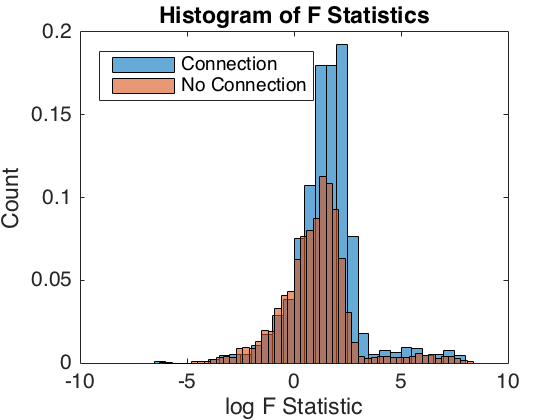

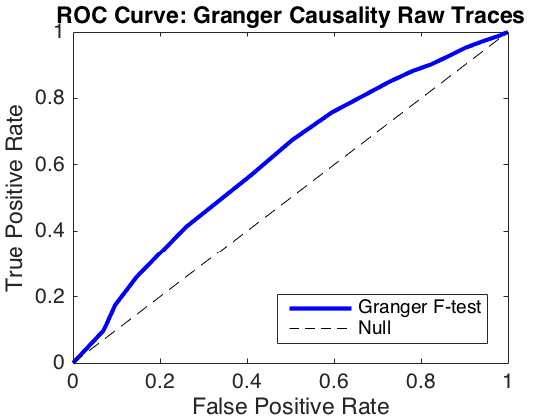

AUROCC: 0.61
Maximum Accuracy at FDR 0.00e+00: 0.82


In [3]:
% get p-vals for each connection, then do Benjamini-Hochberg procedure with
%  p-vals in hand
PVALmat = zeros(numNeurons,numNeurons);
fullParams = (numNeurons-1)*2+histParams+1;
restrictParams = (numNeurons-2)*2+histParams+1;
paramDiff = fullParams-restrictParams;
allInds = 1:numNeurons;

Fstats = zeros(numNeurons,numNeurons);
for ii=1:numNeurons
    inds = find(allInds~=ii);
    for jj=inds
        devFull = connectivityMatrix1(ii,jj);
        devRestrict = connectivityMatrix2(ii,jj);
        F = ((devRestrict-devFull)/paramDiff)/(devFull/(N-fullParams-1));
        temp = fcdf(F,paramDiff,N-fullParams,'upper');
        Fstats(ii,jj) = F;
        if temp<1e-50
            temp = 1e-50;
        end
        PVALmat(ii,jj) = temp;
    end
end

FDR = [0,1e-6,1e-5,1e-4,0.001,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99,0.999,1];
numTests = length(FDR);

truePositives = zeros(numTests,1);
falsePositives = zeros(numTests,1);
accuracy = zeros(numTests,1);

inds = ~diag(ones(numNeurons,1));
vectorPvals = sort(PVALmat(inds));
m = length(vectorPvals);
for ii=1:numTests
    % Benjamini-Hochberg
    alpha = FDR(ii);
    line = (1:m).*(alpha/m);
    difference = vectorPvals-line';
    index = find(difference<=0,1,'last');
    pThreshold = vectorPvals(index);
    
    if isempty(pThreshold) == 1
        pThreshold = min(vectorPvals)/2;
    end
    
    % threshold to get directed connectivity
    newPmat = PVALmat;newPmat(newPmat>=pThreshold) = 0;
    newPmat(newPmat>0) = 1;
    
    
    % convert to undirected connectivity
    undirPmat = newPmat;
    for jj=1:numNeurons
        for kk=1:numNeurons
             if undirPmat(jj,kk)==1
                 undirPmat(kk,jj) = 1;
             end
        end
    end
    onesMatrix = ones(size(undirPmat));
    inds = find(triu(onesMatrix,1));
    undirPvec = undirPmat(inds);
    undirConnVec = undirConnectMat(inds);
    
    % calculate error, etc.
    temp = undirPvec+undirConnVec;
    accuracy(ii) = (sum(sum(temp==2))+sum(sum(temp==0)))/(numNeurons*numNeurons/2-numNeurons);
    
    % get true positive rate
    truePositives(ii) = sum(sum(temp==2))/sum(sum(undirConnVec==1));
    % get false positive rate
    negatives = find(undirConnVec==0);
    guessPositives = find(undirPvec==1);
    falsePositives(ii) = length(intersect(negatives,guessPositives))/length(negatives);
end

figure;
plot(falsePositives,truePositives,'b','LineWidth',2);hold on;
plot(linspace(0,1,numTests),linspace(0,1,numTests),'--k');
title(sprintf('ROC Curve: Granger Causality Raw Traces'));
xlabel('False Positive Rate');ylabel('True Positive Rate');
legend('Granger F-test','Null','Location','SouthEast');

AUC = trapz(falsePositives,truePositives);
fprintf('AUROCC: %3.2f\n',AUC);

[maxAc,ind] = max(accuracy);
fprintf('Maximum Accuracy at FDR %3.2e: %3.2f\n',FDR(ind),maxAc);

onesMatrix = ones(numNeurons,numNeurons);
inds = find(triu(onesMatrix,1));
temp = undirConnectMat(inds);

for ii=1:numNeurons
   for jj=1:numNeurons
       temp1 = Fstats(ii,jj);
       temp2 = Fstats(jj,ii);
       if temp2>temp1
           Fstats(ii,jj) = temp2;
       end
   end
end

Fstats = Fstats(inds);
Fstats1 = Fstats(temp==1);
Fstats0 = Fstats(temp==0);

figure;histogram(log(Fstats1),'normalization','probability');hold on;
histogram(log(Fstats0),'normalization','probability');
legend('Connection','No Connection','Location','Northwest');
title('Histogram of F Statistics');
xlabel('log F Statistic');
ylabel('Count');

As we can see, Granger causality does not provide a very good estimate of network connectivity in this setting. The maximum accuracy occurs by setting every connection to zero, which suggests that as soon as we start declaring connections, we start making mistakes. As I noted above, the model was misspecified for most, if not all, of the neurons. Therefore, we cannot trust the results of the F tests. I think the deterministic calcium decay played a role in generating autocorrelated residuals (specifically the decay of the other neurons, as the decay of the test neuron is largely accounted for by the autoregressive history parameters). It would probably be more appropriate to first deconvolve the spikes from the calcium traces and then fit a Granger causality model using a binomial or Poisson GLM. I do this below ...